Importación de librerías, url y demás datos para el uso en el demo

Previamente se instalaron bibliotecas en la terminal como:
(torch torchvision torchaudio,
torch-geometric,
pandas, etc)

También se ingresó Anaconda

In [1421]:
import numpy as np
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import Subset
import torch.utils.data.dataloader
import torch.utils.data.dataset
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from torch_geometric.data import Data
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


In [1422]:
data_clothes = pd.read_csv('https://raw.githubusercontent.com/myriammmm13/demoDiscrestas/main/clothes_price_prediction_data.csv')

# Codificar las columnas de categorías/atributos
label_encoders = {}
categorias_columnas = ['Brand', 'Category', 'Color', 'Size', 'Material']
todos_columans= ['Brand', 'Category', 'Color', 'Size', 'Material', 'Price']
for columna in categorias_columnas:
    le = LabelEncoder()
    data_clothes[columna] = le.fit_transform(data_clothes[columna])
    label_encoders[columna] = le

# división de los valores a predecir/precio (y) y los atributos a utilizar para predecir (x)
X = data_clothes[categorias_columnas].values
y = data_clothes['Price'].values
t=data_clothes[todos_columans].values

# Paso a tensores
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)
t_tensor = torch.tensor(t, dtype=torch.float32)
print("Características del tensor X:")
print(X_tensor)
print("\nPrecio del tensor:")
print(y_tensor)
print("Tamaño tensor x: ", X_tensor.shape)
print("Tamaño tensor y: ", y_tensor.shape)
print("Tamaño tensor t: ", t_tensor.shape)

Características del tensor X:
tensor([[1., 0., 4., 4., 2.],
        [1., 2., 0., 4., 4.],
        [5., 0., 3., 1., 5.],
        ...,
        [4., 4., 1., 4., 1.],
        [5., 4., 0., 5., 1.],
        [1., 1., 5., 4., 5.]])

Precio del tensor:
tensor([182,  57, 127,  77, 113,  19,  31,  46,  97,  80,  98, 150,  68,  49,
         97, 184,  98,  91, 175,  35,  87,  82,  19, 158, 125,  89, 185,  92,
        109, 187,  39, 157, 157, 152, 177,  42,  19, 195, 137,  42,  41, 161,
        173, 124, 193,  38,  44, 138, 138, 174,  63, 143,  48,  27,  89, 142,
        115,  52, 196,  41, 130,  11,  75, 179,  67,  45, 112, 129,  21, 184,
         92, 101, 138, 152, 109,  63, 150, 131, 180,  94,  78,  16,  57, 137,
        141, 110, 190,  88, 153, 158, 196,  33, 151, 127,  95,  58,  59,  79,
        179, 173, 105, 104,  10, 123, 188,  46, 172,  58, 103, 141, 108,  52,
        122, 159, 137,  10, 148, 124,  53, 196, 137,  33, 197, 140, 131, 108,
         72, 173, 133,  92, 184, 158,  60, 165,  24,  

Con esta celda anterior se logró pasar el dasaset a tensores, siendo dividido los nodos con sus atributos (Material, Size, Brand, etc) y otro tensor con el precio de cada uno.

In [1423]:
#decive
device = (
    "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Usando {device}")

Usando cpu


In [1424]:
data_clothes[data_clothes.columns].nunique()

Brand         6
Category      6
Color         6
Size          6
Material      6
Price       190
dtype: int64

Muestra la cantidad de "variantes" que existen en cada categoría/atributo

In [1425]:
class GCN(nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.red = nn.Sequential(
            nn.Linear(5, 32), 
            nn.ReLU(),
            nn.Linear(32,200),
        )#5=capa entrada, 32=neuronas, 190=capa salida
        #la capa de salida posee 190 porque son la cantidad de "variantes" que se pueden dar en precio :)

    def forward(self, data):
        #pre, edge_index = data.x, data.edge_index
        predd = self.red(data) # Genera la predicción
        return predd
modelo=GCN().to(device)

Se inicializan las clases necesarias para la creación del gcn, además de las capas de entrada, oculta y de salida

In [1426]:
torch.manual_seed(123)

In [1427]:
trai, val, test = torch.utils.data.random_split(
    t_tensor, [0.8, 0.1, 0.1],
)

# Verificar tamaños
print(f'Tamaño set de entrenamiento: {len(trai)}')
print(f'Tamaño set de validación: {len(val)}')
print(f'Tamaño set de prueba: {len(test)}')

# Y verificar el tipo de dato de trai, val y test
print(f'Tipo de dato set "train": {type(trai)}')
print(f'Tipo de dato set "val": {type(val)}')
print(f'Tipo de dato set "test": {type(test)}')

a= trai[200]
print(type(a))

Tamaño set de entrenamiento: 800
Tamaño set de validación: 100
Tamaño set de prueba: 100
Tipo de dato set "train": <class 'torch.utils.data.dataset.Subset'>
Tipo de dato set "val": <class 'torch.utils.data.dataset.Subset'>
Tipo de dato set "test": <class 'torch.utils.data.dataset.Subset'>
<class 'torch.Tensor'>


Esta partición de los datos se realiza para poder usarlos en las 3 etapas a desarollar: Entrenamiento, validación y testeo

In [1428]:
def summary_categorical_dist(df_data, col):
    fig = plt.figure(figsize = (8, 4), facecolor = "white")

    layout_plot = (1, 2)  
    num_subplot = 2
    axes = [None for _ in range(num_subplot)]
    list_shape_subplot = [[(0, 0), (0, 1)], [1, 1], [1, 1]]
    for i in range(num_subplot):
        axes[i] = plt.subplot2grid(
            layout_plot, list_shape_subplot[0][i],
            rowspan = list_shape_subplot[1][i],
            colspan = list_shape_subplot[2][i]
        )
    
    count = df_data[col].value_counts().sort_index()
    
    sns.countplot(data = df_data, y = col, order = count.index, ax = axes[0])
    axes[1].pie(data = df_data, x = count, labels = count.index, autopct = '%1.1f%%', startangle = 90)
    
    list_title = ["Cantidad", "Proporciones"]
    for i in range(num_subplot):
        axes[i].set_title(list_title[i])
    plt.suptitle(f"Distribución de: {col}", fontsize = 15)
    plt.tight_layout()
    plt.show()

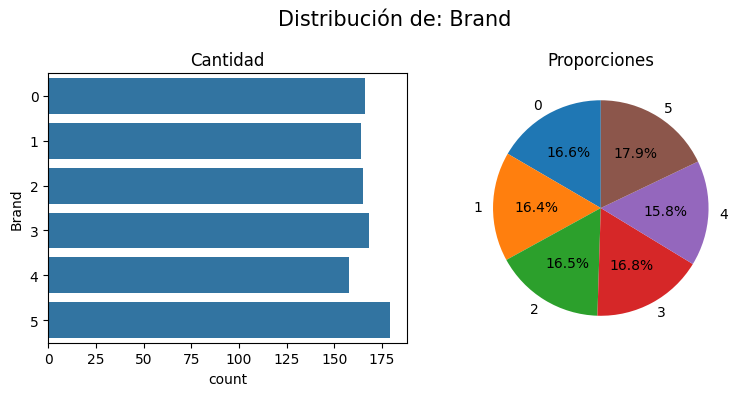

In [1429]:
summary_categorical_dist(data_clothes, 'Brand')

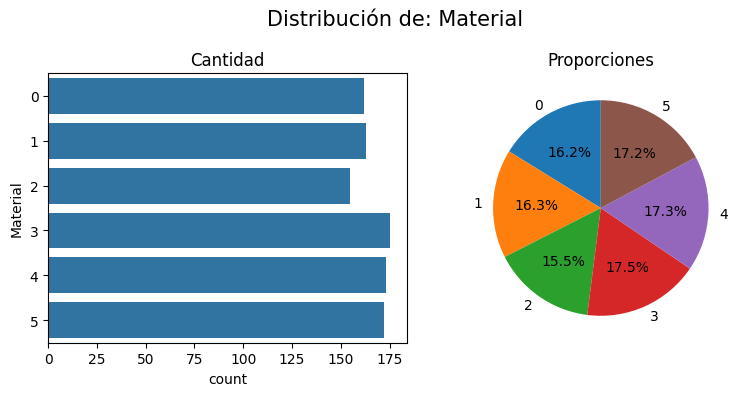

In [1430]:
summary_categorical_dist(data_clothes, 'Material')

¡¡Extra!!
Esta zona se utiliza para hacerse a una idea gráfica del dataset, no tiene una funcionalidad en el entrenamiento como tal.
Con esto me ayudo a darme una mejor idea de cómo se están manejando los datos, ya que en un principio no se tenía la claridad de si se utilizaban como números (por el cambio que se hizo anteriormente) o si se sigue usando con normalidad

In [1431]:
display(data_clothes.describe().round(2).T) 

,count,mean,std,min,25%,50%,75%,max
Brand,1000.0,2.52,1.72,0.0,1.00,3.0,4.0,5.0
Category,1000.0,2.40,1.67,0.0,1.00,2.0,4.0,5.0
Color,1000.0,2.54,1.71,0.0,1.00,3.0,4.0,5.0
Size,1000.0,2.64,1.68,0.0,1.00,3.0,4.0,5.0
Material,1000.0,2.55,1.71,0.0,1.00,3.0,4.0,5.0
Price,1000.0,106.29,53.70,10.0,59.75,108.0,150.0,199.0


Cada número en cada categoria significa una de las 6 posibilidades a existir en ellas. Únicamente en precio varía por las distintas posibilidades que hay entre el 10 y el 199.

In [1432]:
k = 5  # número de vecinos a crear por nodo
adj_matrix = kneighbors_graph(data_clothes.iloc[:, :-1], k, mode='connectivity', include_self=True)
edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)
data_ = Data(x=X_tensor, edge_index=edge_index, y=y_tensor)

c:\Users\Myria\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


Se generan variables que ayudarán al método "train", además de matriz de adyacencia y edge_index

In [1433]:
a1, a2, a3, a4, a5, ind=trai[55]#aquí se puede cambiar el valor de los [] para testear otros nodos
print(trai[55])

nd= [a1, a2, a3, a4, a5]
nd = torch.stack(nd)

tensor([ 3.,  4.,  4.,  5.,  0., 62.])


se obtiene un nodo de prueba, se pasa a tuple, luego a tensor y por último a data para poder realizar la predicción. EL siguiente bloque de código realiza el Forward Propagation

In [1434]:
predd = modelo(nd)

# Predicción
y_pred = predd.argmax()

print(f'Logits: {predd}')
print(f'Categoría predicha: {y_pred}')
print(f'Categoría real: {ind}')

Logits: tensor([ 0.4539,  0.1117,  0.7115,  0.7937,  0.9299, -1.0415,  1.5861,  0.2513,
         0.4273,  0.2919, -0.4183, -0.5231, -1.4996,  1.4313, -0.6240, -0.2605,
         0.2788,  0.4148,  0.2845, -0.5888,  0.7350, -0.6267,  0.3586,  0.5743,
        -0.2470, -1.5289, -0.4203,  0.7593,  0.1860, -0.1825,  0.1324,  0.7709,
         0.0231, -0.1044,  0.7810,  0.3077,  0.4394,  0.5455, -1.4398,  0.6745,
        -1.0590,  0.4941, -0.2226,  0.8127,  0.1327, -1.0340, -0.7917, -1.0661,
         0.5976,  0.5381,  0.0240,  0.5096,  0.2879, -0.6454, -0.9369,  1.0672,
         0.1736,  0.7962, -0.2104,  0.5487,  0.5147, -0.2924, -0.2238, -0.9016,
         0.1426,  0.0875, -0.6365, -0.6185, -0.7802,  0.0874,  0.1174, -0.8032,
         0.1669,  0.5899,  0.8455,  0.8577,  0.8928,  0.2737, -1.1088,  0.0348,
         0.7634, -0.5162,  0.0579,  0.0715, -0.2231, -0.2781,  0.0299, -0.3329,
        -0.4918, -0.5092, -1.3725, -0.7221,  0.3255, -1.0031, -0.4270, -0.3923,
         0.6281,  1.2335,  0.006

Logits equivale a los las predicciones que se han hecho, de ahí se selecciona la mayor en y_pred y esa es la predicción que se compara con el precio real. Ahora se realizará el backward propagation.

In [1435]:
Taza_aprendizaje=0.1
EPOCHS=10
Tam_data=100 #tamaño de los lotes que se enviarán para entrenamiento y validación, para no enviar todo directamente

In [1436]:
m_perdida=nn.CrossEntropyLoss()
optimizador=torch.optim.SGD(modelo.parameters(), Taza_aprendizaje)

In [1437]:
predd = predd.view(1, -1) 
ind = ind.view(-1).long() 

perdida=m_perdida(predd, ind)
print(perdida)
perdida.backward()

optimizador.step()
optimizador.zero_grad()

tensor(5.6864, grad_fn=<NllLossBackward0>)


In [1438]:
def train_loop(dataloader, model, loss_fn, optimizer):
    train_size = len(dataloader.dataset)
    nlotes = len(dataloader)
    model.train()

    perdida_train, exactitud = 0, 0
    
    for nlote, (x) in enumerate(dataloader):
        a,b,c,d,e,f=x[nlote]
        X=[a,b,c,d,e]
        X = torch.stack(X)
        f = f.view(-1).long() 
        logits = model(X)
        logits = logits.view(1, -1) 
        
        loss = loss_fn(logits, f)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        perdida_train += loss.item()
        exactitud += (logits.argmax(1) == f).type(torch.float).sum().item()

        if nlote % 10 == 0:
            ndatos = nlote * dataloader.batch_size
            print(f"\tPérdida: {loss.item():>7f}  [{ndatos:>5d}/{train_size:>5d}]")

    perdida_train /= nlotes
    exactitud /= train_size

    print(f'\tExactitud/pérdida promedio:')
    print(f'\t\tEntrenamiento: {(100*exactitud):>0.1f}% / {perdida_train:>8f}')

In [1439]:
def val_loop(dataloader, model, loss_fn):
    val_size = len(dataloader.dataset)
    nlotes = len(dataloader)
    model.eval()
    perdida_val, exactitud = 0, 0

    with torch.no_grad():
        for ind,(x) in enumerate(dataloader):
            
            a,b,c,d,e,f=x[ind]
            X=[a,b,c,d,e]
            X = torch.stack(X)
            f = f.view(-1).long() 

            logits = model(X)
            logits = logits.view(1, -1) 

            perdida_val += loss_fn(logits, f).item()
            exactitud += (logits.argmax(1) == f).type(torch.float).sum().item()
    perdida_val /= nlotes
    exactitud /= val_size

    print(f"\t\tValidación: {(100*exactitud):>0.1f}% / {perdida_val:>8f} \n")

In [1440]:
train_loader = DataLoader(
    dataset=trai,
    batch_size=Tam_data,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val,
    batch_size=Tam_data,
    shuffle=False
)

In [1441]:
for t in range(EPOCHS):
    print(f"Iteración {t+1}/{EPOCHS}\n-------------------------------")
    train_loop(train_loader, modelo, m_perdida, optimizador)
    val_loop(val_loader, modelo, m_perdida)
print("Modelo entrenado")

Iteración 1/10
-------------------------------
	Pérdida: 4.761125  [    0/  800]
	Exactitud/pérdida promedio:
		Entrenamiento: 0.0% / 5.849262
		Validación: 0.0% / 5.163620 

Iteración 2/10
-------------------------------
	Pérdida: 5.521877  [    0/  800]
	Exactitud/pérdida promedio:
		Entrenamiento: 0.0% / 5.503125
		Validación: 0.0% / 5.112543 

Iteración 3/10
-------------------------------
	Pérdida: 5.652049  [    0/  800]
	Exactitud/pérdida promedio:
		Entrenamiento: 0.0% / 5.325648
		Validación: 0.0% / 5.163546 

Iteración 4/10
-------------------------------
	Pérdida: 4.955112  [    0/  800]
	Exactitud/pérdida promedio:
		Entrenamiento: 0.0% / 5.255251
		Validación: 0.0% / 5.286507 

Iteración 5/10
-------------------------------
	Pérdida: 5.205508  [    0/  800]
	Exactitud/pérdida promedio:
		Entrenamiento: 0.0% / 5.655105
		Validación: 0.0% / 5.195798 

Iteración 6/10
-------------------------------
	Pérdida: 5.209272  [    0/  800]
	Exactitud/pérdida promedio:
		Entrenamiento